##This notebook is to test whether predicted 16S copy number is higher in the early stages of Cladophora colonization in Mike's MS work.

In [1]:
%load_ext rpy2.ipython
# Loading the Rmagic extension

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in after plyr
library(ggplot2)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [3]:
%%R
physeq = import_biom("OTU_table.biom", parseFunction = parse_taxonomy_greengenes)
# Importing the biom file as a phyloseq object, parsing its taxonomy as greengenes format

In [29]:
%%R
write.table(tax_table(physeq),file="Taxonomy.csv", col.names=FALSE, sep=",")
# Saving the OTUs and their phylogeny as a file so Python can import

In [5]:
import pandas as pd

In [6]:
!head -50 rrnDB-4.4.3.tsv
# RRNDP taxa assignments
# That tsv file is downloaded from https://rrndb.umms.med.umich.edu/static/download/

id	rank	name	parentid	childcount	min	max	mode	median	mean	stddev	sum16slist
2689	genus	Thiobacillus	3442	1	2	2	2	2	2.00	0.00	[2]
2690	genus	Odoribacter	3480	1	4	4	4	4	4.00	0.00	[4]
2691	genus	Nocardioides	3539	1	2	2	2	2	2.00	0.00	[2]
2692	genus	Haloarcula	3396	3	3	3	3	3	3.00	0.00	[3, 3, 3]
2693	genus	Vulcanisaeta	3497	2	1	1	1	1.0	1.00	0.00	[1, 1]
2694	genus	Mycobacterium	3527	74	1	2	1	1.0	1.18	0.38	[1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2695	genus	Ignavibacterium	3397	2	1	1	1	1.0	1.00	0.00	[1, 1]
2696	genus	Solibacillus	3535	1	12	12	12	12	12.00	0.00	[12]
2697	genus	Arsenophonus	3537	1	2	2	2	2	2.00	0.00	[2]
2698	genus	Chlorobaculum	3490	1	2	2	2	2	2.00	0.00	[2]
2699	genus	Hyphomonas	3381	1	1	1	1	1	1.00	0.00	[1]
2700	genus	Achromobacter	3439	4	1	3	3	3.0	2.50	0.87	[3, 1, 3, 3]
2701	genus	Slackia	3431	1	2	2	2	

In [7]:
rrnDB = pd.read_table("rrnDB-4.4.3.tsv")
# Importing the table using pandas

In [8]:
rrnDB_d = {}
names = rrnDB[rrnDB["rank"]=="genus"]["name"]
copynum = rrnDB[rrnDB["rank"]=="genus"]["mean"]
for i in range(0,len(names)-1):
    rrnDB_d[names[i]]=copynum[i]
# Now we have the dictionary of the rrnDB database, for which we can look up values of 16S copy number.

In [30]:
! head -50 "Taxonomy.csv" > "minitax.csv"
# Making a mini dataset to play with

In [46]:
fh = open("Taxonomy.csv","r")
output_fh = open("otus.genuses.csv","w")
for line in fh:
    ourlist = line.split(",")
    OTU = ourlist[0]
    genusname = str(ourlist[6])
    genusname = genusname[1:-1]
    if genusname in rrnDB_d.keys():
        copynum = str(rrnDB_d[genusname])
    else:
        copynum = "NA"
    output_fh.write(str(OTU+","+genusname+","+copynum+"\n"))
fh.close()
output_fh.close()
# Now we have a csv with the predicted mean 16S copy number for each OTU, and its genus.

In [88]:
%%R
l2fc<-read.csv("l2fc.csv")
# Import the csv file for log2-fold changes we made in another notebook

In [89]:
%%R
copynum = read.csv("otus.genuses.csv", header=FALSE, col.names = c("OTU","Genus","Copynum"))
# Import the copy number file we just made

In [90]:
%%R
validOTUs = copynum$OTU
l2fcOTUs = unique(l2fc$OTU)
l2fc$Copynum = "NA"
i=0
while (i <= length(l2fcOTUs)) {
    OTU = paste(l2fcOTUs[i]);
    l2fc[l2fc$OTU==OTU,dim(l2fc)[2]] = copynum[copynum$OTU==OTU,]$Copynum;
    i=i+1
}
# Makes a list of the OTUs for which we have matches
# Makes a list of the OTUs from our full data
# Creates a new empty column for copynumbers
# Probably very inefficiently, for each OTU, adds a column to the l2fc file corresponding to that OTU

In [99]:
%%R
d = l2fc%>%
    filter(padj<0.1)%>%
    filter(is.na(Copynum)==FALSE)%>%
    mutate(Copynum=as.numeric(Copynum))

da.lm=lm(data=d,l2FC~Copynum)
da.summary = summary.lm(da.lm)
b=da.summary$coefficients[1,1]
m=da.summary$coefficients[2,1]
da.summary
# Running some stats on the relationships


Call:
lm(formula = l2FC ~ Copynum, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5527 -2.2234 -0.8693  2.5977  9.9262 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.73343    0.18602   3.943 8.39e-05 ***
Copynum     -0.51163    0.04898 -10.447  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.07 on 1662 degrees of freedom
Multiple R-squared:  0.06162,	Adjusted R-squared:  0.06105 
F-statistic: 109.1 on 1 and 1662 DF,  p-value: < 2.2e-16



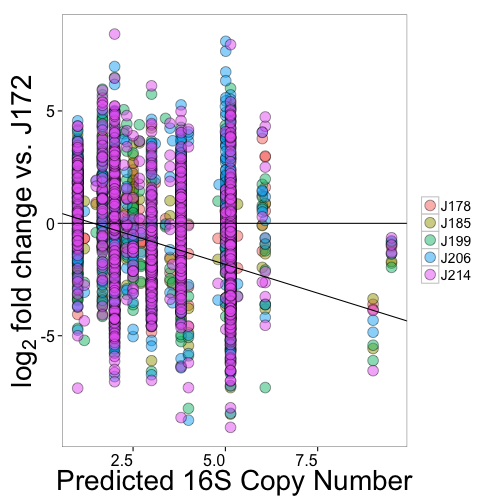

In [105]:
%%R -w 500 -h 500
# setting the image sizes, then making the figure...

FDR = 0.1
cutoff = 0

d = l2fc
d$Copynum = as.numeric(d$Copynum)

d = d %>%
    mutate(sig = ifelse(padj<FDR,1,0))%>%
    filter(pvalue != 'NA')%>%
    filter(Copynum != "NA")
# Cutting out incomplete entries and creating a column indicating significance ("sig")
  
p = ggplot(d, aes(x = Copynum, y = l2FC, fill=Date))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

#p = p + facet_wrap(~Date, scales="free_x",ncol=1)
# saying we want it to present the data separately for our variables (trtmt), in 2 columns
    
p = p + geom_point(shape = 21, alpha=0.5, size=5, jitter=0)
# sets the points size and shape

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. J172",sep="")))
# sets the label for the y axes.

p = p + guides(fill=guide_legend(title=""))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

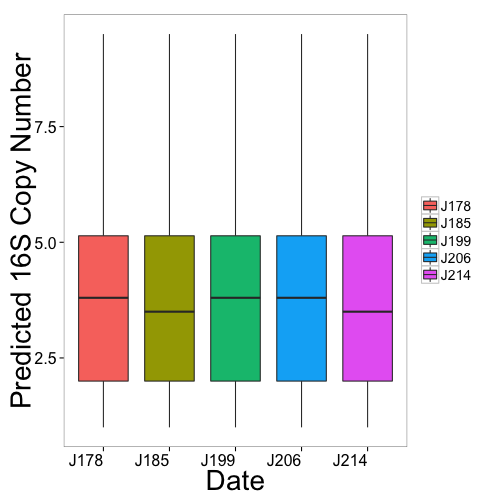

In [106]:
%%R -w 500 -h 500
# setting the image sizes, then making the figure...

FDR = 0.1

d = l2fc
d$Copynum = as.numeric(d$Copynum)

d = d %>%
    mutate(sig = ifelse(padj<FDR,1,0))%>%
    filter(pvalue != 'NA')%>%
    filter(Copynum != "NA")
# Cutting out incomplete entries and creating a column indicating significance ("sig")
  
p = ggplot(d, aes(x = Date, y = Copynum, fill=Date))
# establishing our plot
    
p = p + geom_boxplot()
# sets the boxplots

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(y = "Predicted 16S Copy Number")
p = p + labs(x = "Date")
# sets the label for the axes.

p = p + guides(fill=guide_legend(title=""))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

## Seems like the distribution of predicted 16S copy number doesn't change a lot over this time. It's likely partly because of our limited database, and possibly naming issues (were OTUs named in RDP?) Maybe I missed some matching thing somewhere.

In [93]:
%%R
d = l2fc%>%
    filter(padj<0.1)%>%
    filter(is.na(Copynum)==FALSE)%>%
    mutate(Copynum=as.numeric(Copynum))

da.lm=lm(data=d,l2FC~Copynum+Date+Phylum)
da.summary = summary.lm(da.lm)
b=da.summary$coefficients[1,1]
m=da.summary$coefficients[2,1]
da.summary


Call:
lm(formula = l2FC ~ Copynum + Date + Phylum, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.5119 -2.0457 -0.5335  2.0090 10.0193 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.99507    0.63745  -1.561 0.118710    
Copynum                -0.35458    0.05541  -6.399 2.04e-10 ***
DateJ185               -0.73752    0.26433  -2.790 0.005329 ** 
DateJ199               -0.18153    0.25435  -0.714 0.475522    
DateJ206                0.30856    0.25739   1.199 0.230772    
DateJ214                0.05439    0.24873   0.219 0.826921    
PhylumActinobacteria   -2.22088    0.99888  -2.223 0.026327 *  
PhylumBacteroidetes     0.69294    0.59185   1.171 0.241842    
PhylumChloroflexi      -1.79240    0.76969  -2.329 0.019994 *  
PhylumFirmicutes       -0.44840    1.13316  -0.396 0.692370    
PhylumGemmatimonadetes  2.87671    0.83203   3.457 0.000559 ***
PhylumNitrospirae       3.31242    1.06013   3.125 0.001812 *